In [1]:
!pip install -q pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.8 MB/s eta 0:00:00


In [2]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pyomo.opt import SolverStatus, TerminationCondition
import time

## Subplots

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.cbook
import matplotlib.colors as mcolors
# row 2 col 3
def subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, price_list, access_list, market=None):
  fig, axs = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True, gridspec_kw={'hspace': 0.5})
  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]
  axs[0,0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0,0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
  axs[0,0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)

  level = 0.8
  c = ['#069AF3', '#0343DF', '#FFA500', '#FF4500', '#15B01A', '#006400']
  index = [(1,2), (1,3), (2,1), (2,3), (3,1), (3,2)]
  for i in range(6):
    axs[0,1].plot(iter_list, [p[index[i]] for p in price_list], label=r'$p_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)

  axs[0,2].plot(iter_list, [(market[1,2] * p[1,2] + p[1,3] * market[1,3])/(market[1,2]+market[1,3]) for p in price_list], label=r'$\bar{p}_1$', linewidth=3.0, color='b', alpha=level)
  axs[0,2].plot(iter_list, [(market[2,1] * p[2,1] + p[2,3] * market[2,3])/(market[2,1]+market[2,3]) for p in price_list], label=r'$\bar{p}_2$', linewidth=3.0, color='r', alpha=level)
  axs[0,2].plot(iter_list, [(market[3,1] * p[3,1] + p[3,2] * market[3,2])/(market[3,1]+market[3,2]) for p in price_list], label=r'$\bar{p}_3$', linewidth=3.0, color='g', alpha=level)

  for i in range(6):
    axs[1,1].plot(iter_list, [a[index[i]] for a in access_list], label=r'$A_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)

  axs[1,2].plot(iter_list, [(market[1,2] * a[1,2] + a[1,3] * market[1,3])/(market[1,2]+market[1,3]) for a in access_list], label=r'$\bar{A}_1$', linewidth=3.0, color='b', alpha=level)
  axs[1,2].plot(iter_list, [(market[2,1] * a[2,1] + a[2,3] * market[2,3])/(market[2,1]+market[2,3]) for a in access_list], label=r'$\bar{A}_2$', linewidth=3.0, color='r', alpha=level)
  axs[1,2].plot(iter_list, [(market[3,1] * a[3,1] + a[3,2] * market[3,2])/(market[3,1]+market[3,2]) for a in access_list], label=r'$\bar{A}_3$', linewidth=3.0, color='g', alpha=level)

  for i in range(6):
    axs[1,0].plot(iter_list, [s[index[i]] for s in surplus_list], label=r'$\mathcal{S}_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)

  for i in range(2):
    for j in range(3):
      axs[i,j].set_xlim([0, 1])
      axs[i,j].grid()

  for i in range(2):
    for j in range(3):
      box = axs[i,j].get_position()
      axs[i,j].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
      if (i,j) in [(0,0), (0,2), (1,2)]: # 1 row
        axs[i,j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=3, prop={"size":10})
      else:
        axs[i,j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=3, prop={"size":10})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(18) #28

  plt.show()

## Price and Access Fair Model

In [7]:
def partition(m, n, depth=0):
    if n == depth:
        return [[]]
    return [
        item + [i]
        for i in range(m+1)
        for item in partition(m-i, n, depth=depth+1)
        ]

def combinations(m, n):
  return [[m-sum(p)] + p for p in partition(m, n-1)]

def z(m, n, r):
  z_m = 0
  for comb in combinations(m, n):
    z_m += prod([pow(r[i], comb[i]) for i in range(n)])
  return z_m

def availability(m, n, r):
  z_m = 0
  a = {i: 0 for i in range(1,n+1)}
  for comb in combinations(m, n):
    z_i = prod([pow(r[i], comb[i]) for i in range(n)])
    z_m += z_i
    for i in range(1,n+1):
      if comb[i-1] != 0:
        a[i] += z_i
  b = {i: a[i]/z_m for i in range(1,n+1)}
  return b

In [8]:
def ccdf(q, b, form='l'):
  if form == 'l':
    return max(b * (1-q), 0)
  elif form == 'e':
    return -np.log(q)/b

def surplus(q, b, form='l'):
  if form == 'l':
    return b/2 * q * q
  elif form == 'e':
    return q/b

In [9]:
def optimization_problem(M_star, market, b, n, m, alpha=None, fairness='Price', criteria = 'trip', solver='ipopt', init=None):
  model = ConcreteModel()
  L = [i for i in range(1,n+1)]

  # Step 2: Define the decision
  model.pi = Var(L, domain = NonNegativeReals)
  model.r = Var(L, domain = NonNegativeReals)
  model.q = Var(L, L, domain = NonNegativeReals)

  # Step 3: Define Objective  #ccdf(model.q[i,j], b[i,j], form=form)
  model.revenue = Objective(expr = sum([-log(model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j]*model.pi[i] if i != j else 0 for i in L for j in L]), sense=maximize)

  # constraints
  model.c = ConstraintList()
  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j]*model.r[i] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i]*model.r[k] if k!= i else 0 for k in L]))
    ###
    if fairness == 'Price' and criteria == 'origin':
        m_list += [sum([market[i,j] * -log(model.q[i,j])/b[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j])]
    elif fairness == 'Access' and criteria == 'origin':
        m_list += [sum([market[i,j] * model.q[i,j] * model.pi[i] for j in L if i != j])/sum([market[i,j] for j in L if i != j])]
    ###
    for j in L:
      model.c.add(model.q[i,j] <= 1)
      if i != j and fairness == 'Price' and criteria == 'trip':
        m_list += [-log(model.q[i,j])/b[i,j]]
      elif i != j and fairness == 'Access' and criteria == 'trip':
        m_list += [model.q[i,j] * model.pi[i]]

  z_m = 0
  a = [0 for _ in L]
  for x in combinations(m, n):
    z = prod([pow(model.r[l], x[l-1]) for l in L])
    z_m += z
    for l in L:
      if x[l-1] > 0:
        a[l-1] += z
  model.c.add(z_m == 1)
  for l in L:
    model.c.add(model.pi[l] == a[l-1])

  if alpha != None:
    eps = 1e-3 if alpha == 1 else 0
    for i in range(len(m_list)):
      for j in range(i+1, len(m_list)):
        model.c.add(m_list[i] - m_list[j] <= (1-alpha) * M_star + eps)
        model.c.add(m_list[j] - m_list[i] <= (1-alpha) * M_star + eps)

  if init == None:
    for i in L:
      model.pi[i].value = random.uniform(0, 1)  # Random value between 0 and 1
      model.r[i].value = random.uniform(0, 1)  # Random value between 0 and 1
      for j in L:
          model.q[i, j].value = random.uniform(0, 1)  # Random value between 0 and 1
  else:
    for i in L:
      model.pi[i].value = init['pi'][i]
      model.r[i].value = init['r'][i]
      for j in L:
          model.q[i, j].value = init['q'][i,j]
  _solver = SolverFactory(solver)

  if solver == 'couenne':
    _solver.options['tol'] = 1e-6
    _solver.options['max_iter'] = 10
  _solver.options['max_iter'] = 5000
  results = _solver.solve(model)
  return model

In [10]:
from functools import total_ordering
from re import sub
from pyomo.environ import *
import random

def fair_model(M_star, market, b, n, m, alpha=None, fairness='Price', criteria='trip', num_iter=10):
  L = [i for i in range(1,n+1)]

  solutions = []
  for iter in range(num_iter):
    try:
      model = optimization_problem(M_star, market, b, n, m, alpha=alpha, fairness=fairness, criteria=criteria, solver='ipopt', init=None)
      solutions.append({'model': model,'revenue': model.revenue()})
    except:
      pass

  best_solution = max(solutions, key=lambda sol: sol['revenue'])
  model = best_solution['model']
  p_ij, a_ij, org_q, sur = {}, {}, {}, {}
  total_surplus = 0

  price, sur, access, total_surplus = {}, {}, {}, 0
  for i in L:
    for j in range(1, n+1):
      if i != j:
        sur[i,j] = model.q[i,j]() * model.pi[i]() / b[i,j]
        access[i,j] = model.q[i,j]() * model.pi[i]()
        total_surplus += market[i,j] * sur[i,j]
        price[i,j] = -np.log(model.q[i,j]())/b[i,j]

  p_origin, a_origin = [], []
  for i in L:
    p_origin.append(sum([price[i,j]*market[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))
    a_origin.append(sum([access[i,j]*market[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))

  p_star_trip, a_star_trip = max(price.values()) - min(price.values()), max(access.values())-min(access.values())
  p_star_origin, a_star_origin = max(p_origin) - min(p_origin), max(a_origin)-min(a_origin)

  p_star, a_star = max(price.values())-min(price.values()), max(access.values())-min(access.values())
  star = {'p_star_trip': p_star_trip, 'a_star_trip': a_star_trip, 'p_star_origin': p_star_origin, 'a_star_origin': a_star_origin}

  return model, price, access, org_q, star, {'s': sur, 'ts': total_surplus}

In [11]:
def simulator(market, b, n, m, fairness='Price', criteria='origin', alpha_list = None, num_iter=1):
  L = [i for i in range(1,n+1)]
  star = None
  revenue_list, surplus_list, total_surplus_list, p_list, a_list, q_list = [], [], [], [], [], []

  fm, price, access, org_q, _star, sur_dict = fair_model(None, market, b, n, m, alpha=None, fairness=fairness, criteria=criteria, num_iter = num_iter)
  revenue_list.append(fm.revenue())
  surplus_list.append(sur_dict['s'])
  total_surplus_list.append(sur_dict['ts'])
  p_list.append(price)
  q_list.append(org_q)
  a_list.append(access)

  if fairness == 'Price':
    star = _star['p_star_trip'] if criteria == 'trip' else _star['p_star_origin']
  elif fairness == 'Access':
    star = _star['a_star_trip'] if criteria == 'trip' else _star['a_star_origin']

  alpha_list = [a/10 for a in range(1,11)] if alpha_list == None else alpha_list
  for a in alpha_list:
    print('alpha = %.1f' %a)
    fm, price, access, org_q, _star, sur_dict = fair_model(star, market, b, n, m, alpha=a, fairness=fairness, criteria=criteria, num_iter = num_iter)

    revenue_list.append(fm.revenue())
    surplus_list.append(sur_dict['s'])
    total_surplus_list.append(sur_dict['ts'])
    p_list.append(price)
    q_list.append(org_q)
    a_list.append(access)

  subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, p_list, a_list, market)
  return revenue_list, total_surplus_list, surplus_list, p_list, a_list

## Experiments

In [12]:
n = 3 # location
m = 10

L = [i for i in range(1,n+1)]
market = {(i,j): random.randint(1, 10) for i in L for j in L if i != j}
market.update({(i,j): 0 for i in L for j in L if i == j})
b = {(i,j): random.randint(1, 10) for i in L for j in L}
d = {(i,j): 1 for i in L for j in L}

#####

market ={(1, 2): 4, (1, 3): 7, (2, 1): 5, (2, 3): 8, (3, 1): 10, (3, 2): 2, (1, 1): 0, (2, 2): 0, (3, 3): 0}
b ={(1, 1): 1, (1, 2): 1/7, (1, 3): 1/5, (2, 1): 1, (2, 2): 1, (2, 3): 1/5, (3, 1): 1/8, (3, 2): 1/6, (3, 3): 1}
param = {'market': market, 'b': b, 'n': n, 'm': m, 'd': d}

### Access Fairness

alpha = 0.1
alpha = 0.2
alpha = 0.3
alpha = 0.4


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.5


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.6


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.7


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.8


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.9
alpha = 1.0


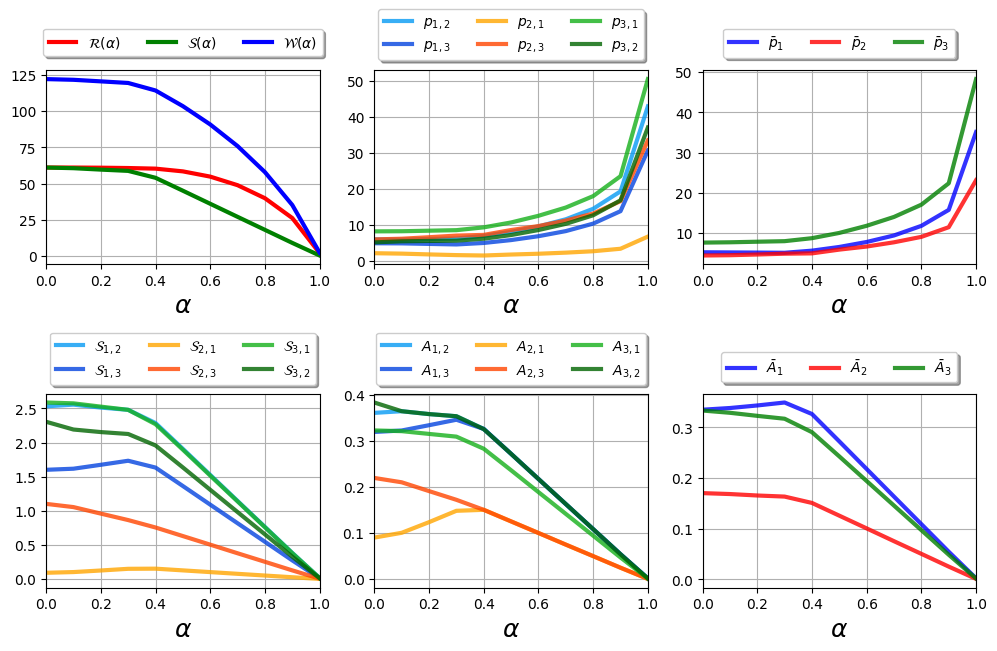

In [13]:
rev_opt, total_sur_opt, sur_opt, p_opt, a_opt = simulator(market, b, n, m, fairness='Access', criteria='trip', num_iter=10)

alpha = 0.1
alpha = 0.2
alpha = 0.3


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.4


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.5


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.6


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.7


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.8


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.
  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.9
alpha = 1.0


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


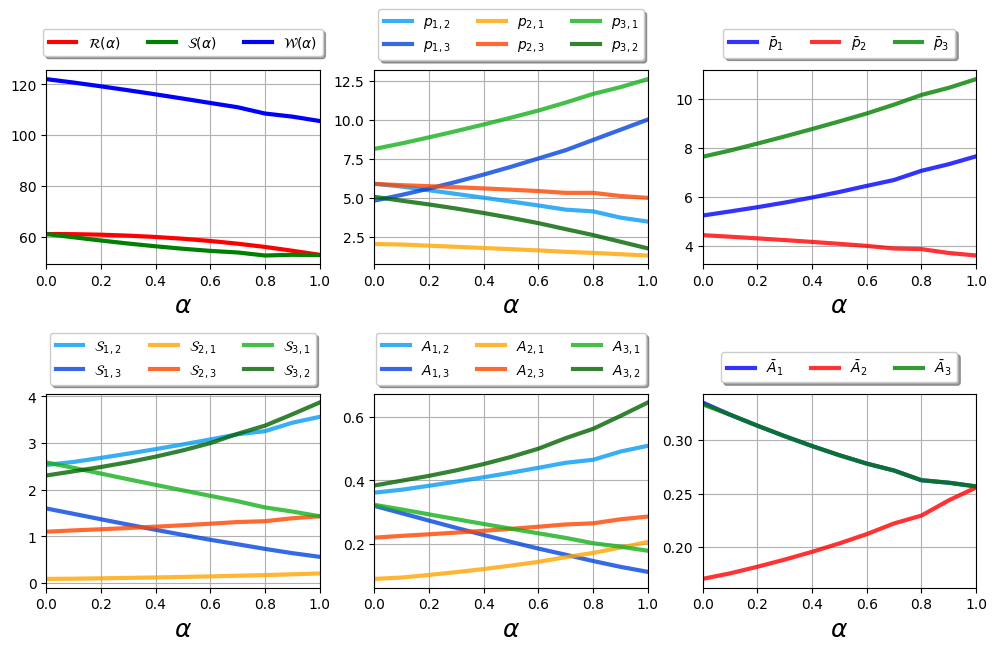

In [14]:
rev_opt, total_sur_opt, sur_opt, p_opt, a_opt = simulator(market, b, n, m, fairness='Access', criteria='origin', num_iter=10)

### Price Fairness

alpha = 0.1
alpha = 0.2


  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


alpha = 0.3
alpha = 0.4
alpha = 0.5


  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


alpha = 0.6
alpha = 0.7
alpha = 0.8
alpha = 0.9
alpha = 1.0


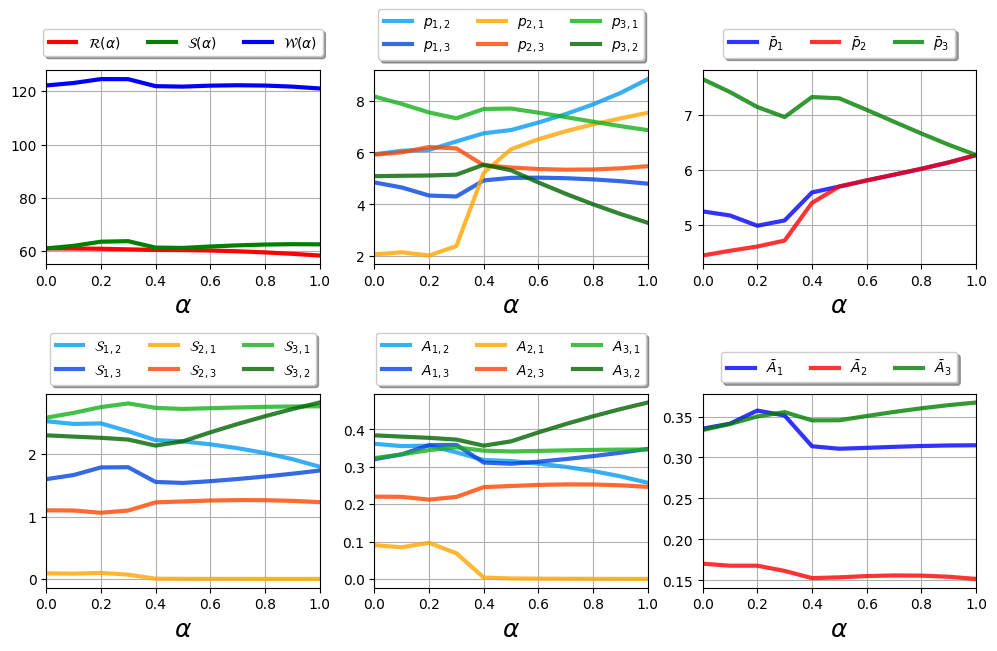

In [15]:
rev_opt, total_sur_opt, sur_opt, p_opt, a_opt = simulator(market, b, n, m, fairness='Price', criteria='origin', num_iter=10)

alpha = 0.1
alpha = 0.2
alpha = 0.3
alpha = 0.4
alpha = 0.5
alpha = 0.6
alpha = 0.7
alpha = 0.8
alpha = 0.9
alpha = 1.0


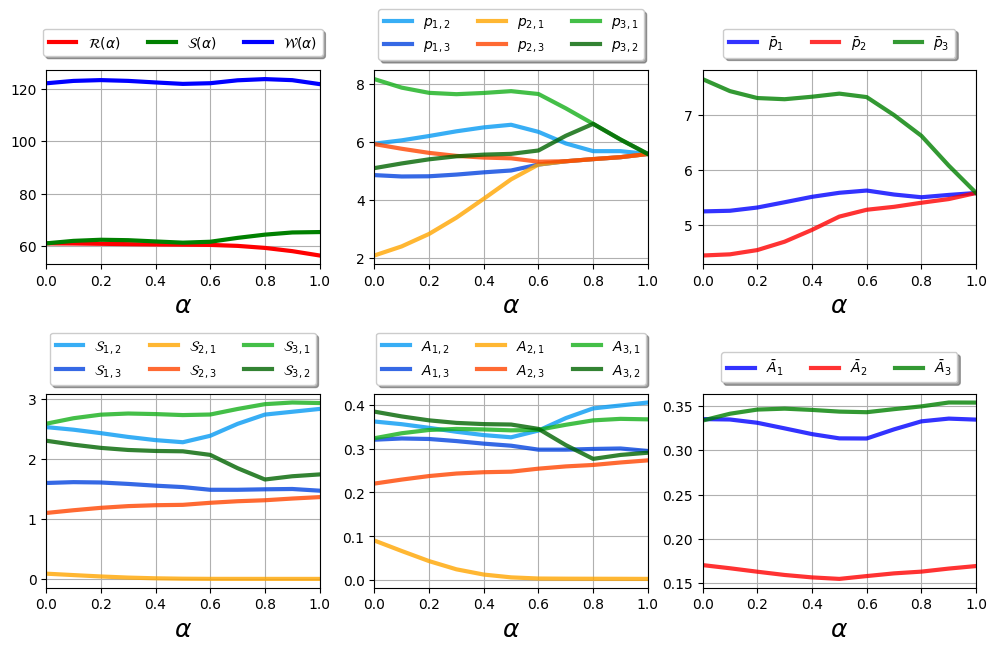

In [16]:
rev_opt, total_sur_opt, sur_opt, p_opt, a_opt = simulator(market, b, n, m, fairness='Price', criteria='trip', num_iter=10)